# Financial Analytics and Complex Derivatives Modeling

This notebook demonstrates advanced financial analytics and modeling techniques for complex derivatives and structured products. We'll cover:

1. Option Contract Basics and Decision Logic
2. Smoothing Techniques for Discontinuous Payoffs
3. Autocallable Options 
4. Bermudan Options and Longstaff-Schwartz Methodology
5. Future Steps: AAD and XVA Integration

In [1]:
import inspect
import numpy as np
from datetime import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import analytics
from contract import Contract, Cashflow, Leg, Option
from observable import Observable, Ticker, Observation
from market import pricing_time_steps

## 1. Option Contract Structure

Our implementation uses a compositional approach where complex products are built from simpler building blocks. The key component is the `Option` class which represents a decision point:

```python
Option(condition, contract1, contract2)
```

- `condition`: Observable that determines which leg is chosen
- If condition is positive → `contract1` is executed
- If condition is negative → `contract2` is executed

This structure supports two types of conditions:
1. Market conditions (e.g., SPX > Strike)
2. Party decisions (e.g., Counterparty call option)

In [2]:
# Example: European call option represented in two ways
expiry = datetime(2025, 1, 1)
strike = 100.0
spx = Ticker("SPX", "INDEX")

# Method 1: Using max function
european_call_1 = Cashflow(
    np.max(Observation(spx, expiry) - strike, 0),
    expiry, "USD", 1.0
)

# Method 2: Using Option structure with market condition
european_call_2 = Option(
    Observation(spx, expiry) - strike,  # Condition
    Cashflow(Observation(spx, expiry) - strike, expiry, "USD", 1.0),  # If positive
    None  # If negative
)

print("Call option using max:")
print(european_call_1)
print("\nCall option using Option structure:")
print(european_call_2)

Call option using max:
max((SPX(2025-01-01) - 100.0), 0))	1.0	USD	2025-01-01

Call option using Option structure:
if (SPX(2025-01-01) - 100.0) is positive then
    (SPX(2025-01-01) - 100.0)	1.0	USD	2025-01-01
else
    None


## 2. Smoothing Discontinuous Payoffs

Digital (or binary) payoffs involve discontinuities which create challenges for path-wise differentiation. We use smoothing techniques to approximate these discontinuities:

### Indicator Function vs Sigmoid

1. **Indicator Function**:
   - 1(x > 0) = 1 if x > 0, 0 otherwise
   - Natural representation of digital payoff
   - Not differentiable at threshold
   - Creates issues for path-wise sensitivities

2. **Sigmoid Function**:
   - Smooth approximation of indicator
   - Continuous and differentiable everywhere
   - Controlled transition around threshold
   - Used in our implementation for smoothing

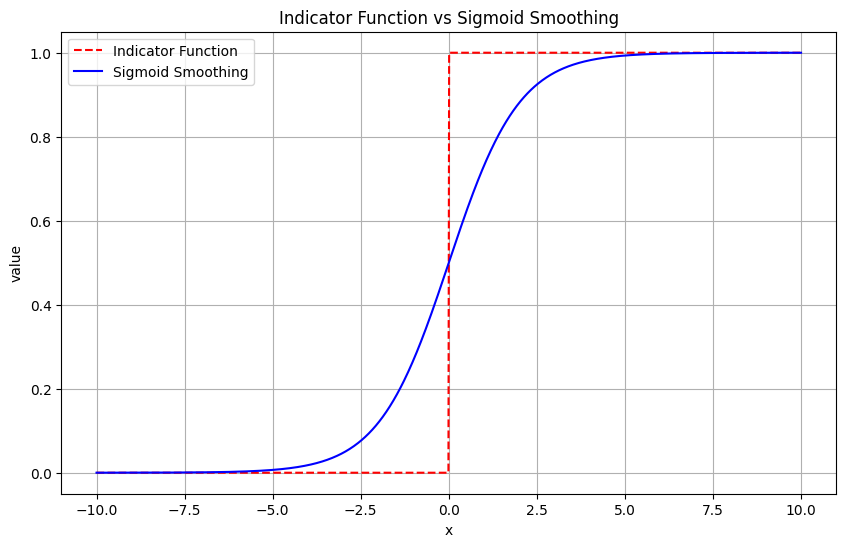

In [3]:
# Visualize indicator vs sigmoid
x = np.linspace(-10, 10, 1000)
sigmoid = 1 / (1 + np.exp(-x))
indicator = x > 0

plt.figure(figsize=(10, 6))
plt.plot(x, indicator, 'r--', label='Indicator Function')
plt.plot(x, sigmoid, 'b-', label='Sigmoid Smoothing')
plt.title('Indicator Function vs Sigmoid Smoothing')
plt.xlabel('x')
plt.ylabel('value')
plt.legend()
plt.grid(True)
plt.show()

## 3. Autocallable Options

Autocallable options have payoffs determined purely by market conditions. They can be fuzzified (smoothed) without a model since no decision estimation is needed.

Let's create and price a European autocallable option using both:
1. Monte Carlo with smoothing
2. Black-Scholes analytical solution

In [5]:
# Market parameters
S0 = 100.0    # Initial price
K = 100.0     # Strike
r = 0.0       # Risk-free rate (for simplicity)
sigma = 0.2   # Volatility
T = 1.0       # Time to expiry in years

# Setup market and model
start_date = datetime(2024, 1, 1)
market_t0 = analytics.Market({"SPX": S0, "USD": 1.0, "EUR": 1.2}, start_date)
model = analytics.Model({"SPX": sigma, "USD": 0.0, "EUR": 0.0}, pricing_time_steps(market_t0))

# Create autocallable option
autocallable = Option(
    Observation(spx, expiry) - K,  # Market condition
    Cashflow(Observation(spx, expiry) - K, expiry, "USD", 1.0),
    None
)

print("Original autocallable:")
print(autocallable)

# Simple fuzzification (no model needed)
fuzzified = analytics.fuzzify_contract(autocallable)
print("\nFuzzified autocallable:")
print(fuzzified)

# Price using Monte Carlo
mc_price = analytics.price_mc_trade(fuzzified, market_t0, model)

# Compare with Black-Scholes
bs_price = analytics.black_scholes_call(S0, K, T, r, sigma)

print(f"\nPricing Comparison:")
print(f"Black-Scholes price: {bs_price:.4f}")
print(f"Monte Carlo price:   {mc_price:.4f}")
print(f"Relative difference: {abs(bs_price - mc_price)/bs_price*100:.2f}%")

# Small difference due to:
# 1. Monte Carlo simulation error
# 2. Effect of sigmoid smoothing vs sharp payoff
# 3. Discretization of time steps in MC

Original autocallable:
if (SPX(2025-01-01) - 100.0) is positive then
    (SPX(2025-01-01) - 100.0)	1.0	USD	2025-01-01
else
    None

Fuzzified autocallable:
(sigmoid((SPX(2025-01-01) - 100.0))) * (SPX(2025-01-01) - 100.0))	1.0	USD	2025-01-01

Pricing Comparison:
Black-Scholes price: 7.9656
Monte Carlo price:   8.0240
Relative difference: 0.73%


## 4. Bermudan Options and Longstaff-Schwartz

A Bermudan option allows exercise at multiple pre-specified dates. We'll create one with two exercise dates:
1. First exercise date at 1 year
2. Second exercise date at 2 years

At each date, the holder can:
- Exercise the option for payoff (S - K)
- Continue to hold the option

The Longstaff-Schwartz algorithm helps estimate optimal exercise decisions by comparing:
- Immediate exercise value
- Expected continuation value (via regression)

In [6]:
# Create a Bermudan option with two exercise dates
first_exercise = datetime(2025, 1, 1)   # 1Y
second_exercise = datetime(2026, 1, 1)  # 2Y

# Build nested option structure
bermudan = Option(
    Observation(Ticker("Call", "CPTY"), first_exercise),  # First exercise decision
    Option(                                               # If not exercised at first date
        Observation(Ticker("Call", "CPTY"), second_exercise),  # Second exercise decision
        Cashflow(Observation(spx, second_exercise) - strike, second_exercise, "USD", 1.0),  # Exercise at 2Y
        None                                                                                # Expire worthless
    ),
    Cashflow(Observation(spx, first_exercise) - strike, first_exercise, "USD", 1.0)  # Exercise at 1Y
)

print("Original Bermudan option structure:")
print(bermudan)

# Transform using Longstaff-Schwartz (requires model)
transformed = analytics.fuzzify_callable_contract(bermudan, market_t0, model)

print("\nTransformed Bermudan option (with estimated exercise conditions):")
print(transformed)

# Price using Monte Carlo
price = analytics.price_mc_trade(transformed, market_t0, model)
print(f"\nBermudan option price: {price:.4f}")

Original Bermudan option structure:
if Call(2025-01-01) is positive then
    if Call(2026-01-01) is positive then
        (SPX(2026-01-01) - 100.0)	1.0	USD	2026-01-01
    else
        None
else
    (SPX(2025-01-01) - 100.0)	1.0	USD	2025-01-01

Transformed Bermudan option (with estimated exercise conditions):
((sigmoid(((((CHEB4_SPX(2025-01-01) * -1.547295335242001) + ((CHEB3_SPX(2025-01-01) * -10.755300717571968) + ((CHEB2_SPX(2025-01-01) * 12.146815453441416) + ((EUR(2025-01-01) * -4.884981308350689e-15) + ((SPX(2025-01-01) * -0.37073576621413135) + 64.08662235968538))))) + 0) - 0))) * sigmoid(((((CHEB4_SPX(2026-01-01) * 4.917744387596094e-16) + ((CHEB3_SPX(2026-01-01) * 5.728004563883431e-16) + ((CHEB2_SPX(2026-01-01) * 4.6467895845021e-16) + ((EUR(2026-01-01) * -7.395570986446986e-32) + ((SPX(2026-01-01) * 1.0000000000000007) + -100.00000000000007))))) + 0) - 0)))) * (SPX(2026-01-01) - 100.0))	1.0	USD	2026-01-01
(((sigmoid(((((CHEB4_SPX(2025-01-01) * -1.547295335242001) + ((CHEB3_SP

## 5. Future Work

### AAD Integration
- Current implementation ready for AAD
- Smooth payoffs enable path-wise differentiation
- Future: add computation recording for backwards differentiation

### XVA Framework
1. CVA/DVA with exposure profiles
2. FVA with funding costs
3. MVA/KVA for margin modeling

### Implementation Steps
1. Add AAD recording layer
2. Implement exposure profiles
3. Add collateral modeling
4. Calculate XVA metrics